# Credit Risk Default - Model Version 2 - "In Progress"

Improvements to include:

* Add Early Stopping rounds = 50

* Create two new predictive features to help model 



# Feature Engineer new predictive measures 

The recent payment ratio is an important financial feature that can improve 
the performance of credit default prediction models in machine learning. 

Here's how they contribute:

## 1. Recent Payment Ratio

Definition:

The ratio of recent payments made by a borrower to their total recent billing or due amount over the last 6 months.

Calculation: __recent_payment_ratio = total_recent_payment_amount / total_recent_bill_amount__


## 2. Average Payment & bill Amount

Definition:

Detects variability and consistency in payments. Sharp drops may suggest financial strain.

Calculation: 

__mean(payment_amount over last 6 months)__

__mean(bill_amount over last 6 months)__



In [1]:
#Libaries and dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import issparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import joblib
from sqlalchemy import create_engine
from collections import Counter

In [2]:
db_config = {
    "user": "INSERT",
    "password": "INSERT",
    "host": "localhost",
    "port": 5432,
    "database": "credit_etl"
}

engine = create_engine(f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

In [3]:

query = "select * from raw.raw_customer_default_payment"

credit_data = pd.read_sql(query, engine)
credit_data

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [5]:
#create x and y variables 

#Make a copy of the DataFrame so you don't modify the original one.
x = credit_data.copy()

#6 columns of monthly payments and convert them to a NumPy array.
recent_payments_values = x[['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6']].values
recent_bill_values = x[['bill_amt1','bill_amt2','bill_amt3','bill_amt4', 'bill_amt5','bill_amt6']].values

#create new measures 
recent_payments = np.nan_to_num(recent_payments_values.sum(axis=1), nan=0)
recent_bills = np.nan_to_num(recent_bill_values.sum(axis=1), nan=0)
recent_payment_avg = np.nan_to_num(recent_payments_values.mean(axis=1), nan=0)
recent_bill_avg = np.nan_to_num(recent_bill_values.mean(axis=1), nan=0)

#this avoids diveision with zero add a nan for any zero value
x['recent_payment_ratio'] = np.divide(recent_payments, recent_bills, where=recent_bills != 0, out=np.zeros_like(recent_payments, dtype=float))
x['recent_payment_ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
x['avg_payment_amt_6mts'] = recent_payment_avg
x['avg_bill_amt_6mts'] = recent_bill_avg

x_new = x

In [6]:
x_new.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,recent_payment_ratio,avg_payment_amt_6mts,avg_bill_amt_6mts
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,689,0,0,0,0,1,0.089434,114.833333,1284.000000
1,2,120000,2,2,2,26,-1,2,0,0,...,0,1000,1000,1000,0,2000,1,0.292791,833.333333,2846.166667
2,3,90000,2,2,2,34,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0.108388,1836.333333,16942.166667
3,4,50000,2,2,1,37,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,0.036259,1398.000000,38555.666667
4,5,50000,1,2,1,57,-1,0,-1,0,...,2000,36681,10000,9000,689,679,0,0.540054,9841.500000,18223.166667


In [7]:
y = x_new['default_payment_next_month']
x = x_new.drop(columns=['default_payment_next_month', 'id'])

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

## New Feature Importance:

Axes(0.125,0.11;0.775x0.77)


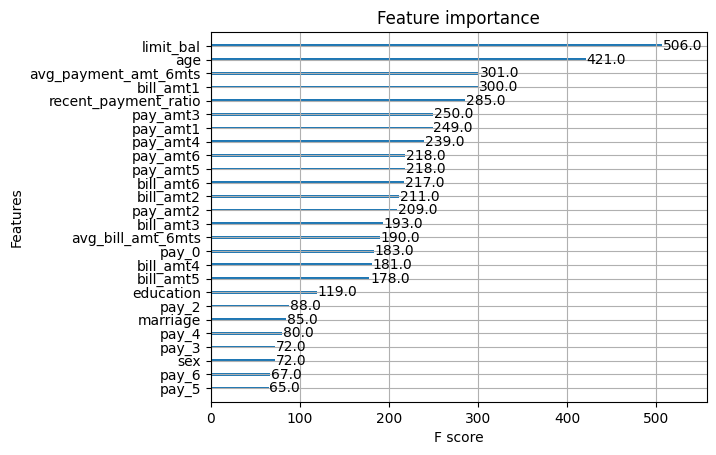

In [8]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

model= xgb.XGBRegressor(eval_metric='auc')
model.fit(x_train, y_train)

print(xgb.plot_importance(model, importance_type='weight')) #most important features